In [126]:
from itertools import product
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

**Files description**

* sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.
* test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.
* sample_submission.csv - a sample submission file in the correct format.
* items.csv - supplemental information about the items/products.
* item_categories.csv  - supplemental information about the items categories.
* shops.csv- supplemental information about the shops.


### Loading data

In [127]:
data_path = os.path.join('datasets', 'future_sales')

sales_train_path = os.path.join(data_path, 'sales_train.csv')
train_df = pd.read_csv(sales_train_path)

test_path = os.path.join(data_path, 'test.csv')
test_df = pd.read_csv(test_path)

items_path = os.path.join(data_path, 'items.csv')
temp_df = pd.read_csv(items_path)
train_df = pd.merge(train_df, temp_df, on='item_id', how='left')

items_category_path = os.path.join(data_path, 'item_categories.csv')
temp_df = pd.read_csv(items_category_path)
train_df = pd.merge(train_df, temp_df, on='item_category_id', how='left')

shops_path = os.path.join(data_path, 'shops.csv')
temp_df = pd.read_csv(shops_path)
train_df = pd.merge(train_df, temp_df, on='shop_id', how='left')

print('Shape: ', train_df.shape)

Shape:  (2935849, 10)


### Data Fields

* ID - an Id that represents a (Shop, Item) tuple within the test set
* shop_id - unique identifier of a shop
* item_id - unique identifier of a product
* item_category_id - unique identifier of item category
* item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
* item_price - current price of an item
* date - date in format dd/mm/yyyy
* date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
* item_name - name of item
* shop_name - name of shop
* item_category_name - name of item category

Using only shop ids and item ids which are present in test dataset.

In [128]:
test_shop_id = test_df['shop_id'].unique()
test_item_id = test_df['item_id'].unique()

train_df = train_df.loc[train_df['shop_id'].isin(test_shop_id)]
train_df = train_df.loc[train_df['item_id'].isin(test_item_id)]
train_df.shape

(1224439, 10)

No string features

In [129]:
train_df.drop(columns=['item_name', 'item_category_name', 'shop_name'], inplace=True)
train_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
0,02.01.2013,0,59,22154,999.0,1.0,37
10,03.01.2013,0,25,2574,399.0,2.0,55
11,05.01.2013,0,25,2574,399.0,1.0,55
12,07.01.2013,0,25,2574,399.0,1.0,55
13,08.01.2013,0,25,2574,399.0,2.0,55


## Visualisations

In [130]:
train_df['sales'] = train_df['item_price'] * train_df['item_cnt_day']

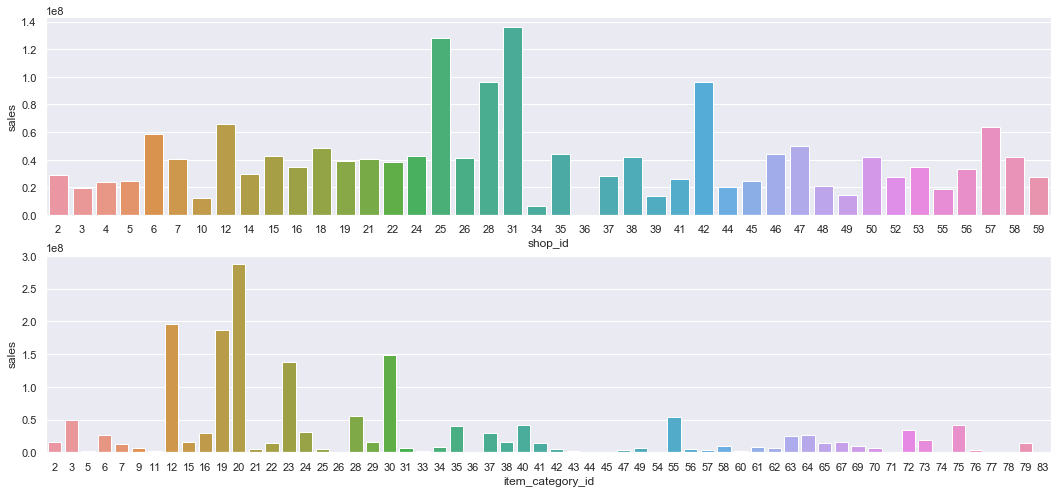

In [117]:
fig, ax = plt.subplots(2, 1, figsize=(18,8))
total_shop = train_df.groupby('shop_id', as_index=False)['sales'].sum()
sns.barplot(x='shop_id', y='sales', data=total_shop, ax=ax[0])

total_shop = train_df.groupby('item_category_id', as_index=False)['sales'].sum()
sns.barplot(x='item_category_id', y='sales', data=total_shop, ax=ax[1])

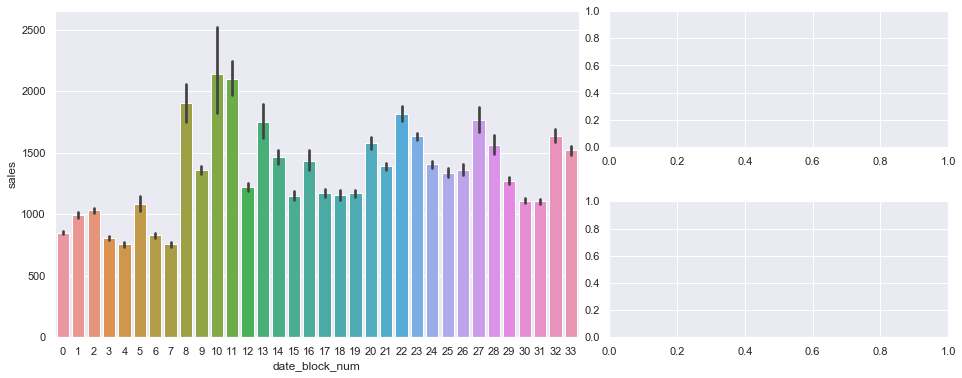

In [7]:
fig = plt.figure(figsize=(16, 6))
grid = plt.GridSpec(2, 5, hspace=0.4)

ax1 = fig.add_subplot(grid[:, 0:3])
ax2 = fig.add_subplot(grid[0, 3:])
ax3 = fig.add_subplot(grid[1, 3:])
date_block_group = train_df.groupby('date_block_num')
sns.barplot(x='date_block_num', y='sales', data=train_df, ax=ax1)

## Cleaning

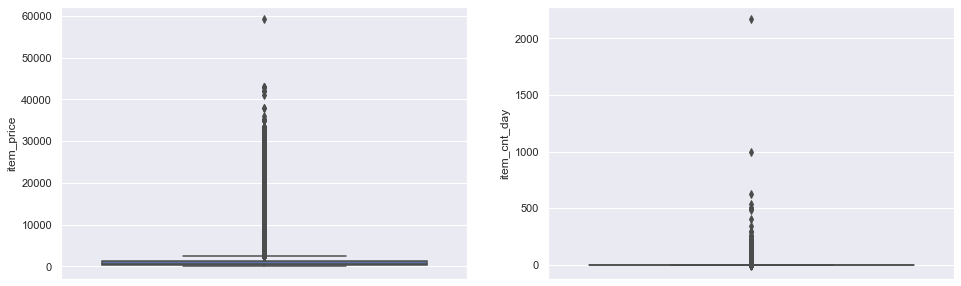

In [131]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
sns.boxplot(y=train_df['item_price'], ax=ax1)
sns.boxplot(y=train_df['item_cnt_day'], ax=ax2)

In [132]:
cols_to_group = ['date_block_num', 'shop_id', 'item_category_id', 'item_id']
train_group = train_df.groupby(cols_to_group).agg({'item_price': [np.mean, np.sum],
                                                   'item_cnt_day': [np.mean, np.sum]})
train_group.reset_index(inplace=True)
train_group.columns = cols_to_group + ['price_mean', 'price', 'cnt_mean', 'cnt']

In [133]:
train_group.head()

,date_block_num,shop_id,item_category_id,item_id,price_mean,price,cnt_mean,cnt
0,0,2,2,5572,1532.857143,10730.00,1.285714,9.0
1,0,2,2,5643,2387.605000,4775.21,0.000000,0.0
2,0,2,5,5583,594.150000,1188.30,1.000000,2.0
3,0,2,6,7893,1990.000000,5970.00,1.000000,3.0
4,0,2,6,7894,1490.000000,1490.00,1.000000,1.0


In [134]:
shop_ids = train_group['shop_id'].unique()
item_ids = train_group['item_id'].unique()
date_blocks = train_group['date_block_num'].unique()
empty_df = list(product(date_blocks, shop_ids, item_ids))
    
empty_df = pd.DataFrame(empty_df, columns=['date_block_num','shop_id','item_id'])
all_train = pd.merge(empty_df, train_group, on=['date_block_num','shop_id','item_id'], how='left')
all_train.fillna(0, inplace=True)

In [135]:
all_train.describe().T

,count,mean,std,min,25%,50%,75%,max
date_block_num,6734448.0,16.500000,9.810709,0.0,8.00,16.5,25.00,33.000000
shop_id,6734448.0,31.642857,17.561894,2.0,16.00,34.5,47.00,59.000000
item_id,6734448.0,11041.890161,6210.744436,30.0,5385.25,11265.5,16068.25,22167.000000
item_category_id,6734448.0,3.786271,13.212956,0.0,0.00,0.0,0.00,83.000000
price_mean,6734448.0,81.230111,534.732650,0.0,0.00,0.0,0.00,42990.000000
price,6734448.0,187.392884,2177.443736,0.0,0.00,0.0,0.00,515573.589744
cnt_mean,6734448.0,0.097299,0.612203,-2.0,0.00,0.0,0.00,1000.000000
cnt,6734448.0,0.240223,3.456640,-4.0,0.00,0.0,0.00,2253.000000


### EDA

Removing outliers

In [136]:
all_train = all_train.loc[(all_train['cnt'] <= 20) 
                          & (all_train['cnt'] >= 0) 
                          & (all_train['price'] < 400_000)]

In [137]:
def get_year(x):
    return x // 12 + 2013

def get_month(x):
    return x % 12

all_train['year'] = all_train['date_block_num'].apply(get_year)
all_train['month'] = all_train['date_block_num'].apply(get_month)
all_train['sales'] = all_train['cnt'] * all_train['price']

In [138]:
all_train.describe().T

,count,mean,std,min,25%,50%,75%,max
date_block_num,6728118.0,16.498777,9.811429,0.0,8.0,16.0,25.0,33.0
shop_id,6728118.0,31.643428,17.563488,2.0,16.0,35.0,47.0,59.0
item_id,6728118.0,11042.868904,6209.703870,30.0,5386.0,11266.0,16068.0,22167.0
item_category_id,6728118.0,3.752608,13.156585,0.0,0.0,0.0,0.0,83.0
price_mean,6728118.0,79.816626,525.620638,0.0,0.0,0.0,0.0,42990.0
price,6728118.0,169.801052,1797.753805,0.0,0.0,0.0,0.0,366860.0
cnt_mean,6728118.0,0.093249,0.312189,0.0,0.0,0.0,0.0,20.0
cnt,6728118.0,0.185153,0.907449,0.0,0.0,0.0,0.0,20.0
year,6728118.0,2013.941146,0.802274,2013.0,2013.0,2014.0,2015.0,2015.0
month,6728118.0,5.205026,3.323107,0.0,2.0,5.0,8.0,11.0


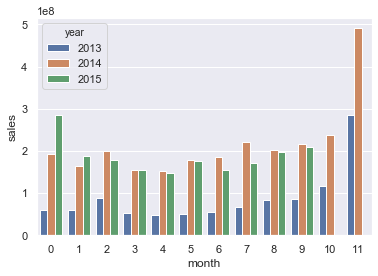

In [139]:
temp = all_train.groupby(['year', 'month'])[['price', 'cnt', 'sales']].sum()
temp.reset_index(inplace=True)
sns.barplot(x='month', y='sales', hue='year', data=temp)

## Feature engineering

In [140]:
cols_to_group = ['shop_id', 'item_category_id', 'item_id']
all_train['lag_price'] = all_train.sort_values('date_block_num').groupby(cols_to_group)['price'].shift(-1)
all_train['lag_cnt'] = all_train.sort_values('date_block_num').groupby(cols_to_group)['cnt'].shift(-1)
all_train['lag_2_cnt'] = all_train.sort_values('date_block_num').groupby(cols_to_group)['cnt'].shift(-2)
all_train['lag_3_cnt'] = all_train.sort_values('date_block_num').groupby(cols_to_group)['cnt'].shift(-3)
cols = ['lag_cnt', 'lag_2_cnt', 'lag_3_cnt', 'lag_price']
all_train[cols] = all_train[cols].fillna(0)

In [141]:
rolling_mean = lambda x: x.rolling(window=3, min_periods=1).mean()
rolling_min = lambda x: x.rolling(window=3, min_periods=1).min()
rolling_max = lambda x: x.rolling(window=3, min_periods=1).max()

all_train['rolling_mean_cnt'] = all_train.sort_values('date_block_num') \
                                         .groupby(cols_to_group)['cnt'].apply(rolling_mean)
all_train['rolling_min_cnt'] = all_train.sort_values('date_block_num') \
                                        .groupby(cols_to_group)['cnt'].apply(rolling_min)
all_train['rolling_max_cnt'] = all_train.sort_values('date_block_num') \
                                        .groupby(cols_to_group)['cnt'].apply(rolling_max)

In [142]:
all_train['change_cnt'] = all_train['cnt'] - all_train['lag_cnt']
all_train['change_2_cnt'] = all_train['cnt'] - all_train['lag_2_cnt']
all_train['change_3_cnt'] = all_train['cnt'] - all_train['lag_3_cnt']

In [143]:
all_train['target'] = all_train.sort_values('date_block_num').groupby(['shop_id', 'item_id'])['cnt'].shift(1)

In [144]:
all_train.describe().T

,count,mean,std,min,25%,50%,75%,max
date_block_num,6728118.0,16.498777,9.811429,0.0,8.0,16.0,25.0,33.0
shop_id,6728118.0,31.643428,17.563488,2.0,16.0,35.0,47.0,59.0
item_id,6728118.0,11042.868904,6209.703870,30.0,5386.0,11266.0,16068.0,22167.0
item_category_id,6728118.0,3.752608,13.156585,0.0,0.0,0.0,0.0,83.0
price_mean,6728118.0,79.816626,525.620638,0.0,0.0,0.0,0.0,42990.0
price,6728118.0,169.801052,1797.753805,0.0,0.0,0.0,0.0,366860.0
cnt_mean,6728118.0,0.093249,0.312189,0.0,0.0,0.0,0.0,20.0
cnt,6728118.0,0.185153,0.907449,0.0,0.0,0.0,0.0,20.0
year,6728118.0,2013.941146,0.802274,2013.0,2013.0,2014.0,2015.0,2015.0
month,6728118.0,5.205026,3.323107,0.0,2.0,5.0,8.0,11.0


## One item

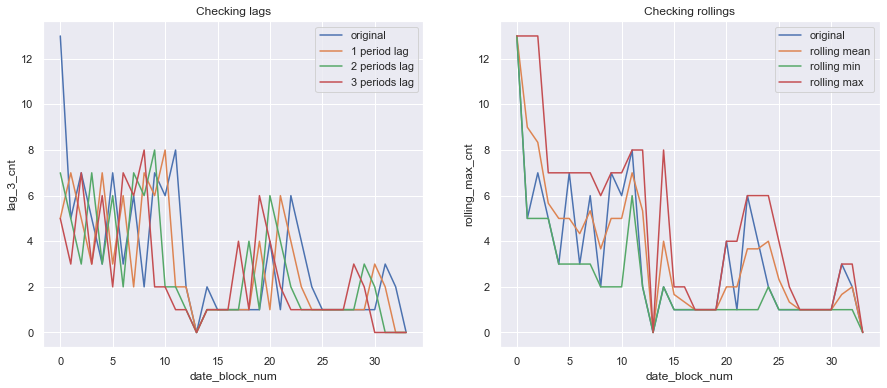

In [145]:
one_item = all_train.loc[(all_train['shop_id'] == 25) & (all_train['item_id'] == 8093)]

fig, ax = plt.subplots(1, 2, figsize=(15, 6))
sns.lineplot(x='date_block_num', y='cnt', data=one_item, ax=ax[0], label='original')
sns.lineplot(x='date_block_num', y='lag_cnt', data=one_item, ax=ax[0], label='1 period lag')
sns.lineplot(x='date_block_num', y='lag_2_cnt', data=one_item, ax=ax[0], label='2 periods lag')
sns.lineplot(x='date_block_num', y='lag_3_cnt', data=one_item, ax=ax[0], label='3 periods lag')
ax[0].legend()
ax[0].set_title('Checking lags')

sns.lineplot(x='date_block_num', y='cnt', data=one_item, ax=ax[1], label='original')
sns.lineplot(x='date_block_num', y='rolling_mean_cnt', data=one_item, ax=ax[1], label='rolling mean')
sns.lineplot(x='date_block_num', y='rolling_min_cnt', data=one_item, ax=ax[1], label='rolling min')
sns.lineplot(x='date_block_num', y='rolling_max_cnt', data=one_item, ax=ax[1], label='rolling max')
ax[1].legend()
ax[1].set_title('Checking rollings');

In [ ]:
one_item.head()

In [146]:
all_train.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
date_block_num,6728118.0,16.50,9.81,0.0,8.0,16.0,25.0,33.0
shop_id,6728118.0,31.64,17.56,2.0,16.0,35.0,47.0,59.0
item_id,6728118.0,11042.87,6209.70,30.0,5386.0,11266.0,16068.0,22167.0
item_category_id,6728118.0,3.75,13.16,0.0,0.0,0.0,0.0,83.0
price_mean,6728118.0,79.82,525.62,0.0,0.0,0.0,0.0,42990.0
price,6728118.0,169.80,1797.75,0.0,0.0,0.0,0.0,366860.0
cnt_mean,6728118.0,0.09,0.31,0.0,0.0,0.0,0.0,20.0
cnt,6728118.0,0.19,0.91,0.0,0.0,0.0,0.0,20.0
year,6728118.0,2013.94,0.80,2013.0,2013.0,2014.0,2015.0,2015.0
month,6728118.0,5.21,3.32,0.0,2.0,5.0,8.0,11.0


### Preprocessing

In [157]:
df = all_train.loc[all_train['date_block_num'] > 2].copy()

In [148]:
columns = ['lag_price', 'lag_cnt', 'lag_2_cnt', 'lag_3_cnt', 'rolling_mean_cnt',
           'rolling_min_cnt', 'rolling_max_cnt']
for col in columns:
    print(col)
    temp = df.groupby(['shop_id'])[col].median()
    df = pd.merge(df, temp, left_on='shop_id', right_index=True, suffixes=('', '_y'), how='left')
    df.loc[df[col].isna(), col] = df[f'{col}_y']
    df.drop(columns=f'{col}_y', inplace=True)

col_means = df[columns].mean()
df[columns].fillna(col_means, inplace=True)

lag_price
lag_cnt
lag_2_cnt
lag_3_cnt
rolling_mean_cnt
rolling_min_cnt
rolling_max_cnt


C:\Users\Bartek\anaconda3\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


## Machine learning

In [150]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error

In [162]:
train_df = df.loc[df['date_block_num'] < 28].copy()
valid_df = df.loc[df['date_block_num'] >= 28].copy()

for set_ in [train_df, valid_df]:
    set_.drop(columns=['date_block_num', 'sales'], inplace=True)
print(f'Valid split: {valid_df.shape[0] / (train_df.shape[0] + valid_df.shape[0])}')

Valid split: 0.19357719407668333


Adding features after spliting

In [163]:
shop_mean = train_df.groupby('shop_id')['cnt'].mean()
shop_mean = shop_mean.reset_index()
shop_mean.rename(columns={'cnt': 'shop_mean'}, inplace=True)
train_df = pd.merge(train_df, shop_mean, on='shop_id', how='left')
valid_df = pd.merge(valid_df, shop_mean, on='shop_id', how='left')

item_mean = train_df.groupby('item_id')['cnt'].mean()
item_mean = item_mean.reset_index()
item_mean.rename(columns={'cnt': 'item_mean'}, inplace=True)
train_df = pd.merge(train_df, item_mean, on='item_id', how='left')
valid_df = pd.merge(valid_df, item_mean, on='item_id', how='left')

shop_item_mean = train_df.groupby(['shop_id', 'item_id'])['cnt'].mean()
shop_item_mean = shop_item_mean.reset_index()
shop_item_mean.rename(columns={'cnt': 'shop_item_mean'}, inplace=True)
train_df = pd.merge(train_df, shop_item_mean, on=['shop_id', 'item_id'], how='left')
valid_df = pd.merge(valid_df, shop_item_mean, on=['shop_id', 'item_id'], how='left')

category_mean = train_df.groupby('item_category_id')['cnt'].mean()
category_mean = category_mean.reset_index()
category_mean.rename(columns={'cnt': 'category_mean'}, inplace=True)
train_df = pd.merge(train_df, category_mean, on='item_category_id', how='left')
valid_df = pd.merge(valid_df, category_mean, on='item_category_id', how='left')

In [164]:
X_train = train_df.drop(columns='target')
Y_train = train_df['target']

X_valid = valid_df.drop(columns='target')
Y_valid = valid_df['target']

In [165]:
rf_features = ['shop_id', 'item_id', 'cnt', 'year', 'lag_cnt', 
               'shop_mean', 'item_mean', 'change_cnt', 'rolling_mean_cnt']

model = RandomForestRegressor(verbose=2)
model.fit(X_train[rf_features], Y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   20.1s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 33.1min finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=2, warm_start=False)

In [167]:
Y_pred = model.predict(X_valid[rf_features])
np.sqrt(mean_squared_error(Y_valid, Y_pred))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   32.7s finished


0.6922297917501299

In [81]:
x = pd.DataFrame(list(zip(X_train.columns, model.feature_importances_)), columns=['feature', 'imp'])

In [84]:
x.sort_values('imp', ascending=False)

,feature,imp
6,cnt,0.525240
11,lag_2_cnt,0.120092
12,lag_3_cnt,0.046772
1,item_id,0.043050
8,month,0.039568
5,cnt_mean,0.037655
0,shop_id,0.028987
9,lag_price,0.027848
4,price,0.024882
10,lag_cnt,0.023520


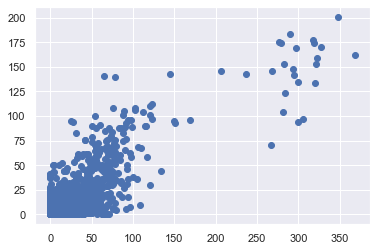

In [111]:
plt.scatter(Y_valid, Y_pred)